### AIM: determine whether an ML algorithm can predict a galaxy group's M200 given the galaxy's (pre-calculated) $\Sigma_M$, $\Sigma_5$, Mstar, and group Ngal.

#### Training M200 values are taken from Tempel+2017's group catalog, as are environment flags

#### $\Sigma_M$ and $\Sigma_5$ are both density-related parameters to characterize a galaxy's local environment and are calculated using my own algorithms found in `../wisesize/environment_classifications`

#### Mstar is from the NED-LVS catalog (Cook+21)
---
#### Why use ML?

##### We are using Tempel+2014 and Tempel+2017 filament and group/cluster catalogs (respectively) to characterize the environments of the WISESize sample.

##### The projected WISESize footprint, however, is a few degrees beyond the SDSS (Tempel) projection.

##### There are thus many galaxies (23%) along the permieter of our sample without environment flags.

##### Attempts to find a linear relationship between log(M200) and any single 2D projected density parameter just produced a nontrivial amount of noise.

##### Rather than discard 23% of the galaxies, I was thus compelled to try machine learning.

### Step Zero
#### Load modules and catalogs

In [45]:
#load modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score
from astropy.table import Table
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
import seaborn as sns

from ML_M200_functions import *

import os
homedir=os.getenv('HOME')

In [46]:
#load tables
#note -- each catalog has already been matched with WISESize (with 10" error)
path = homedir+'/Desktop/wisesize/'
nedlvs_parent = Table.read(path+'nedlvs_parent_v1.fits')
main_nedlvs = Table.read(path+'/archive_tables/NEDLVS_20210922_v2.fits')

nedlvs_parent['Mstar']=np.log10(main_nedlvs['Mstar'])
#nedlvs_parent['SFR_hybrid']=np.log10(main_nedlvs['SFR_hybrid'])
#nedlvs_parent['Lum_W1']=np.log10(main_nedlvs['Lum_W1'])
#nedlvs_parent['Lum_W3']=np.log10(main_nedlvs['Lum_W3'])
#nedlvs_parent['Lum_NUV']=np.log10(main_nedlvs['Lum_NUV'])

#these flags will be important later on when creating the ML models!
raflag = (nedlvs_parent['RA']>87) & (nedlvs_parent['RA']<300)
decflag = (nedlvs_parent['DEC']>-10) & (nedlvs_parent['DEC']<85)
mstarflag = nedlvs_parent['Mstar_all_flag']
zflag = (nedlvs_parent['Z']>0.002) & (nedlvs_parent['Z']<0.025)

#these are ALL flags applied to the input cat table for Sigma_*
wisesize_flag = (mstarflag) & (zflag) & (raflag) & (decflag)

#WISESize sample flag
#wisesize_flag = nedlvs_parent['WISESize_flag']

#want to only isolate Tempel+2017 galaxies. None of the non-Tempel galaxies!
tempel_flag = (nedlvs_parent['tempel2017_flag'])  

#flag to isolate Tempel+2017 groups
group_flag = (nedlvs_parent['tempel2017_groupIDs']>0)

### Step 1a (Optional)
#### Generate a few $\Sigma_k$ and $\Sigma_{M}$ (and Ngal) columns for testing
#### Save outputs to .npy files

In [3]:
#create list of parameters which will be inputted into some fun little function wrappers
#which run my density scripts. these parameter represent the bounds within which the density
#will be calculated for each central galaxy

#vr_limit in km/s, radius_limit in Mpc

vr_limits_M = [1000,1500,1500,500,600,1000,1000,1000,1000,300,300,300,1000,2000,300,1000,100,1500]
radius_limits = [1.5,1.5,1.0,1.0,1.0,0.75,0.5,1.0,2.0,2.0,1.5,0.25,0.25,2.0,1.0,3.0,0.1,3.0]
vr_limits_k = [1000,1000,1000,1000,1000]
k_list = [2,3,5,10,20]

In [4]:
#get list of Sigma_M and Sigma_Ngal features along with a corresponding list of column names (for later)
SigmaM_features, SigmaM_names = generate_SigmaM_variants(vr_limits_M, radius_limits)

Calculating Sigma_M and Ngal for vr_limit = 1000 and radius_limit = 1.5


/Users/k215c316/github/wisesize/environment_classifications/mstar_local_density.py:232: UserWarning: Warning: converting a masked element to nan.
  all_Sigma_Mstar[n] = galaxy.density_Mstar


Number of galaxies with no Sigma_M: 592
Finished in 2.35 minutes


/Users/k215c316/github/wisesize/ML_project/ML_M200_functions.py:286: RuntimeWarning: invalid value encountered in log10
  features_SigmaM.append(np.log10(all_Sigma_Mstar))
/Users/k215c316/github/wisesize/ML_project/ML_M200_functions.py:287: RuntimeWarning: invalid value encountered in log10
  features_logNgal.append(np.log10(all_ngal))


Calculating Sigma_M and Ngal for vr_limit = 1500 and radius_limit = 1.5
Number of galaxies with no Sigma_M: 592
Finished in 2.30 minutes
Calculating Sigma_M and Ngal for vr_limit = 1500 and radius_limit = 1.0
Number of galaxies with no Sigma_M: 394
Finished in 2.34 minutes
Calculating Sigma_M and Ngal for vr_limit = 500 and radius_limit = 1.0
Number of galaxies with no Sigma_M: 394
Finished in 2.31 minutes
Calculating Sigma_M and Ngal for vr_limit = 600 and radius_limit = 1.0
Number of galaxies with no Sigma_M: 394
Finished in 2.32 minutes
Calculating Sigma_M and Ngal for vr_limit = 1000 and radius_limit = 0.75
Number of galaxies with no Sigma_M: 311
Finished in 2.33 minutes
Calculating Sigma_M and Ngal for vr_limit = 1000 and radius_limit = 0.5
Number of galaxies with no Sigma_M: 191
Finished in 2.32 minutes
Calculating Sigma_M and Ngal for vr_limit = 1000 and radius_limit = 1.0
Number of galaxies with no Sigma_M: 394
Finished in 2.33 minutes
Calculating Sigma_M and Ngal for vr_limit 

In [5]:
#get list of Sigma_k features along with a corresponding list of column names (for later)
Sigmak_features, Sigmak_names = calculate_Sigmak_variants(vr_limits_k, k_list)

Running kNN density calculation with k=2, vr_limit=1000, radius_limit=100
NED-LVS catalog selected with 26193 galaxies after applying flags.


/Users/k215c316/github/wisesize/environment_classifications/kNN_local_density.py:194: RuntimeWarning: divide by zero encountered in scalar divide
  self.density_kSigma = self.k / (np.pi * r_k**2)


# galaxies with no valid kNN: 0
Finished in 2.79 minutes
Running kNN density calculation with k=3, vr_limit=1000, radius_limit=100
NED-LVS catalog selected with 26193 galaxies after applying flags.
# galaxies with no valid kNN: 0
Finished in 2.78 minutes
Running kNN density calculation with k=5, vr_limit=1000, radius_limit=100
NED-LVS catalog selected with 26193 galaxies after applying flags.
# galaxies with no valid kNN: 0
Finished in 2.78 minutes
Running kNN density calculation with k=10, vr_limit=1000, radius_limit=100
NED-LVS catalog selected with 26193 galaxies after applying flags.
# galaxies with no valid kNN: 0
Finished in 2.78 minutes
Running kNN density calculation with k=20, vr_limit=1000, radius_limit=100
NED-LVS catalog selected with 26193 galaxies after applying flags.
# galaxies with no valid kNN: 0
Finished in 2.78 minutes


In [6]:
#just in case I need to save the variables at any point so I can restart the Notebook kernel

filename=homedir+'/Desktop/SigmaMfeatures'
np.save(filename,np.array(SigmaM_features,dtype=object))

filename=homedir+'/Desktop/SigmaMnames'
np.save(filename,np.array(SigmaM_names,dtype=object))

filename=homedir+'/Desktop/Sigmakfeatures'
np.save(filename,np.array(Sigmak_features,dtype=object))

filename=homedir+'/Desktop/Sigmaknames'
np.save(filename,np.array(Sigmak_names,dtype=object))

### Step 1b (Optional)

#### Create row-matched dataframe to parent catalog, save df for later use

In [49]:
#row match the columns to parent galaxy catalog!
nedlvs_parent = rowmatch_to_catalog(nedlvs_parent, SigmaM_features, SigmaM_names, Sigmak_features, Sigmak_names)

#let's first create our dataframe if it does not already exist

#apply the trimming flags we discussed earlier!
#note: we will isolate Tempel+2017 group galaxies later on, in particular for where we use halo mass
nedlvs_parent_test = nedlvs_parent[tempel_flag & wisesize_flag]

#and then...
df = nedlvs_parent_test.to_pandas()

#replace -999 with NaNs
df.replace(-999, np.nan, inplace=True)

#REMOVE NaNs
df = df.dropna()

#save progress...just in case.
df.to_csv(homedir+'/Desktop/ML_features.csv', index=False)

In [50]:
try:
    df = pd.read_csv(homedir+'/Desktop/ML_features.csv')
except:
    print('You will have to run all of the Sigma_* variants again...have a time!')
    print('Open the "Generate..." tab above to continue.')

In [48]:
#just in case I need to save the variables at any point so I can restart the Notebook kernel
#I can then avoid generating all of those features...again...for 30+ minutes.

SigmaM_features = np.load(homedir+'/Desktop/SigmaMfeatures.npy', allow_pickle=True).tolist()
SigmaM_names = np.load(homedir+'/Desktop/SigmaMnames.npy', allow_pickle=True).tolist()
Sigmak_features = np.load(homedir+'/Desktop/Sigmakfeatures.npy', allow_pickle=True).tolist()
Sigmak_names = np.load(homedir+'/Desktop/Sigmaknames.npy', allow_pickle=True).tolist()

#row match the columns to parent galaxy catalog!
#nedlvs_parent = rowmatch_to_catalog(nedlvs_parent, SigmaM_features, SigmaM_names, Sigmak_features, Sigmak_names)

### Step Two: Run the model scripts!
#### Be sure to edit the relevant parameters.txt file beforehand
##### (For Random Forest Regression, rf_regression_parameters.txt)
##### (For Random Forest Classification, rf_classification_parameters.txt)
#### To print "help" text, use -h or --help
##### e.g., %run ML_M200_regression.py -h
##### python ML_M200_regression.py -h
#### User has option to input a df or list of feature names; otherwise, run Steps 1a and 1b above to generate features and the df row-matched to the galaxy parent sample.

#### MODEL ONE
##### Random Forest Regression
###### Using Tempel+2017 groups and log(M200)
###### Best result (all log(M200)): MSE = 0.663 | R² = 0.553 (all features; test_size=0.15)
###### Best result (log(M200)>11.5): MSE = 0.240 | R² = 0.656 (all features; test_size=0.20)

---
Let us run the code.

What are the confidence intervals? Why do we include them?
* We want to find the model-predicted log(M200) threshold, at or below which the model becomes unreliable
* For each bin of predicted log(M200), each around 0.30 dex in width, calculate the median and spread of the "true" log(M200) values. 
* If the model is predicting some log(M200) for a large array of "true" log(M200), then the model is not doing well.
* That is, we cannot trust galaxies that are assigned that predicted log(M200), since it very likely does not represent the "true" log(M200) value.
* While I attempted to automate the detection of this threshold log(M200), the most reliable approach is 'by eye.'
* This involves...finding where the CI widths become noticeably tighter about the median curve (solid black).
* As such, most of the printed text regarding bins and CI widths and counts may be disregarded.
---
Note that the “vertical striping” effect is due to galaxies in the same group/cluster having the same “true” log(M200) but obviously different predicted log(M200). This effect is most noticeable for galaxies with the largest log(M200) simply because they contain 20+ galaxies in their group/cluster halo.

_________________________

Model diagnostics for all group galaxies:

R²: 0.534 (R: 0.731)

MSE: 0.720

_________________________

Model diagnostics for Ngal [> 3.0 group galaxies only]:

R²: 0.389 (R: 0.623)

MSE: 0.403

_________________________

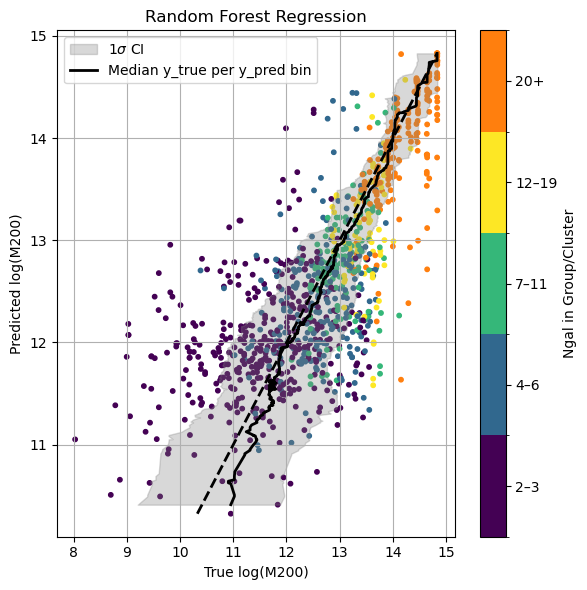

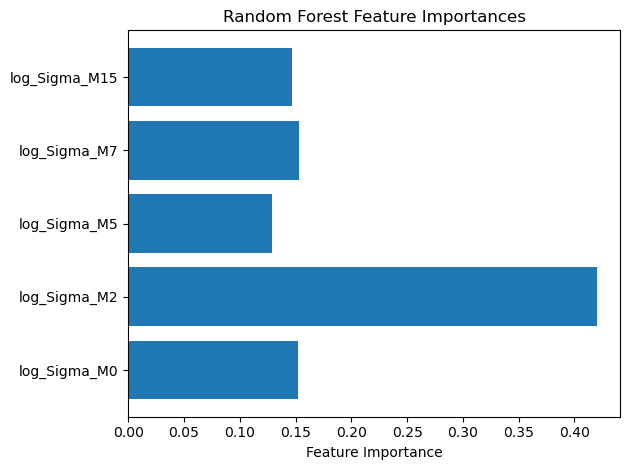

In [5]:
#version with Random Forest
%run ML_M200_regression.py

- Regression failing due to heteroscedasticity, measurement noise, or outliers (i.e., low-mass systems are all mapped to a floor).

- Prediction collapse around log(M200) ≈ 13 — suggesting the model is defaulting to the mean or median because it can't resolve differences on account of the first bullet point.

In [92]:
#let's have a look at how the 68% confidence intervals hinge on the number of features
%run plot_regression_CI.py

regression_CI_vary_features(df, full_feature_list, param_dict)

regression_CI_vary_state(df, param_dict)

Using the following list of features ['log_Sigma_M0', 'log_Sigma_M2', 'log_Sigma_M5', 'log_Sigma_M7', 
'log_Sigma_M15']:

Using 20 "random state(s)" for RFR model...

_________________________

Model diagnostics for all group galaxies:

R²: 0.530 (R: 0.728)

MSE: 0.727

_________________________

Model diagnostics for Ngal [> 3.0 group galaxies only]:

R²: 0.380 (R: 0.617)

MSE: 0.408

_________________________

Using 22 "random state(s)" for RFR model...

_________________________

Model diagnostics for all group galaxies:

R²: 0.532 (R: 0.729)

MSE: 0.724

_________________________

Model diagnostics for Ngal [> 3.0 group galaxies only]:

R²: 0.387 (R: 0.622)

MSE: 0.404

_________________________

Using 24 "random state(s)" for RFR model...

_________________________

Model diagnostics for all group galaxies:

R²: 0.532 (R: 0.729)

MSE: 0.724

_________________________

Model diagnostics for Ngal [> 3.0 group galaxies only]:

R²: 0.387 (R: 0.622)

MSE: 0.404

_________________________

Using 26 "random state(s)" for RFR model...

_________________________

Model diagnostics for all group galaxies:

R²: 0.531 (R: 0.729)

MSE: 0.724

_________________________

Model diagnostics for Ngal [> 3.0 group galaxies only]:

R²: 0.387 (R: 0.622)

MSE: 0.404

_________________________

Using 28 "random state(s)" for RFR model...

_________________________

Model diagnostics for all group galaxies:

R²: 0.530 (R: 0.728)

MSE: 0.726

_________________________

Model diagnostics for Ngal [> 3.0 group galaxies only]:

R²: 0.377 (R: 0.614)

MSE: 0.410

_________________________

Using 30 "random state(s)" for RFR model...

_________________________

Model diagnostics for all group galaxies:

R²: 0.532 (R: 0.729)

MSE: 0.723

_________________________

Model diagnostics for Ngal [> 3.0 group galaxies only]:

R²: 0.390 (R: 0.625)

MSE: 0.402

_________________________

Using 32 "random state(s)" for RFR model...

_________________________

Model diagnostics for all group galaxies:

R²: 0.529 (R: 0.727)

MSE: 0.728

_________________________

Model diagnostics for Ngal [> 3.0 group galaxies only]:

R²: 0.384 (R: 0.620)

MSE: 0.406

_________________________

Using 34 "random state(s)" for RFR model...

_________________________

Model diagnostics for all group galaxies:

R²: 0.534 (R: 0.731)

MSE: 0.720

_________________________

Model diagnostics for Ngal [> 3.0 group galaxies only]:

R²: 0.387 (R: 0.622)

MSE: 0.404

_________________________

Using 36 "random state(s)" for RFR model...

_________________________

Model diagnostics for all group galaxies:

R²: 0.531 (R: 0.728)

MSE: 0.725

_________________________

Model diagnostics for Ngal [> 3.0 group galaxies only]:

R²: 0.385 (R: 0.621)

MSE: 0.405

_________________________

Using 38 "random state(s)" for RFR model...

_________________________

Model diagnostics for all group galaxies:

R²: 0.532 (R: 0.730)

MSE: 0.723

_________________________

Model diagnostics for Ngal [> 3.0 group galaxies only]:

R²: 0.387 (R: 0.622)

MSE: 0.404

_________________________

Using 40 "random state(s)" for RFR model...

_________________________

Model diagnostics for all group galaxies:

R²: 0.533 (R: 0.730)

MSE: 0.722

_________________________

Model diagnostics for Ngal [> 3.0 group galaxies only]:

R²: 0.387 (R: 0.622)

MSE: 0.404

_________________________

Using 42 "random state(s)" for RFR model...

_________________________

Model diagnostics for all group galaxies:

R²: 0.534 (R: 0.731)

MSE: 0.720

_________________________

Model diagnostics for Ngal [> 3.0 group galaxies only]:

R²: 0.389 (R: 0.623)

MSE: 0.403

_________________________

Using 44 "random state(s)" for RFR model...

_________________________

Model diagnostics for all group galaxies:

R²: 0.533 (R: 0.730)

MSE: 0.721

_________________________

Model diagnostics for Ngal [> 3.0 group galaxies only]:

R²: 0.387 (R: 0.622)

MSE: 0.404

_________________________

Using 46 "random state(s)" for RFR model...

_________________________

Model diagnostics for all group galaxies:

R²: 0.533 (R: 0.730)

MSE: 0.722

_________________________

Model diagnostics for Ngal [> 3.0 group galaxies only]:

R²: 0.393 (R: 0.627)

MSE: 0.400

_________________________

Using 48 "random state(s)" for RFR model...

_________________________

Model diagnostics for all group galaxies:

R²: 0.530 (R: 0.728)

MSE: 0.726

_________________________

Model diagnostics for Ngal [> 3.0 group galaxies only]:

R²: 0.384 (R: 0.620)

MSE: 0.406

_________________________

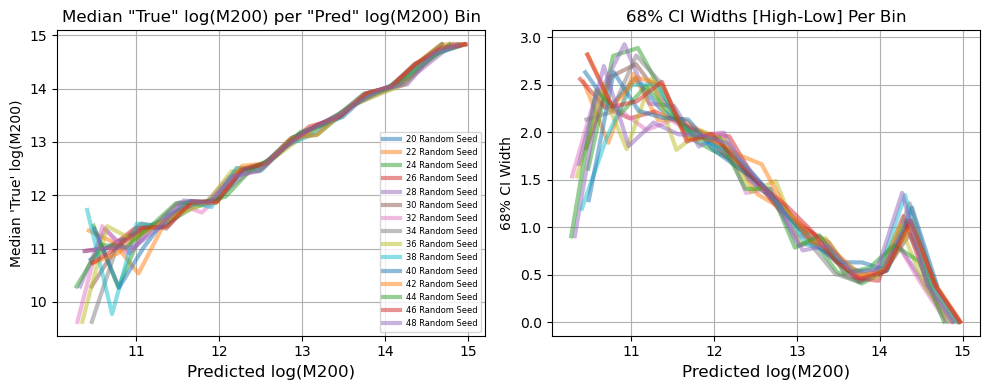

In [93]:
regression_CI_vary_state(df, param_dict)

_________________________

Model diagnostics for all group galaxies:

R²: 0.534 (R: 0.731)

MSE: 0.720

_________________________

Model diagnostics for Ngal [> 3.0 group galaxies only]:

R²: 0.389 (R: 0.623)

MSE: 0.403

_________________________

norm_area=False; normalizing Gaussian fit to the height of the histogram.

Note: Curve fits are scaled vertically for plotting purposes; does not affect mean or 1-sigma of the fit!

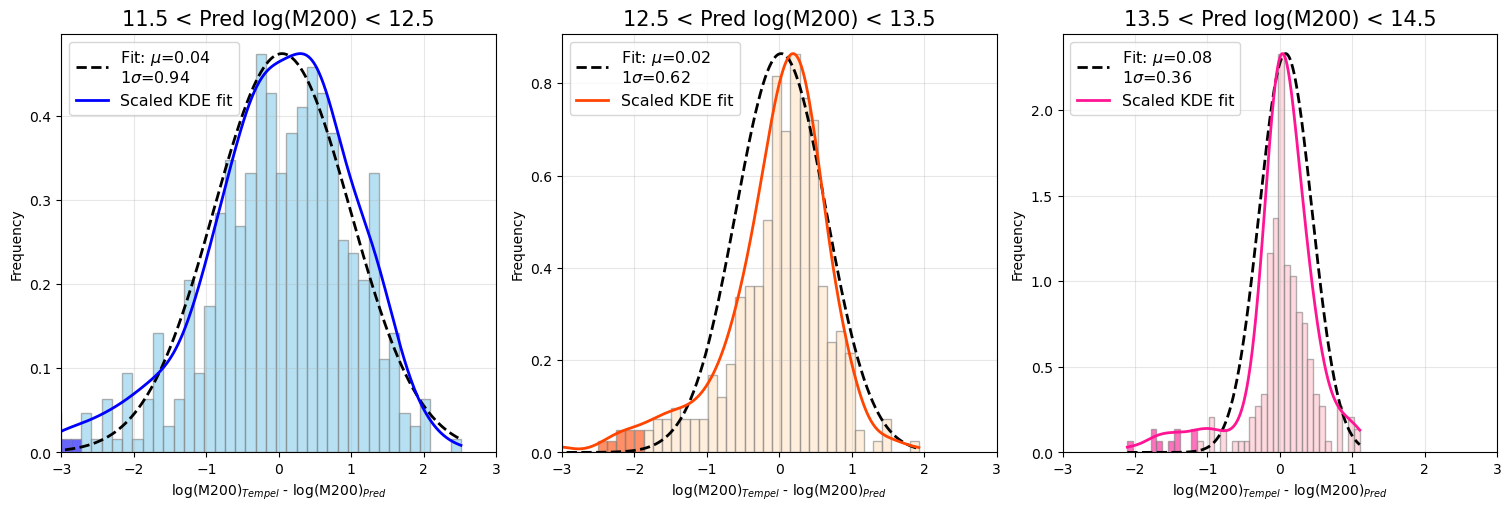

In [201]:
#now look at (gaussian?) distribution of y_test in bins of y_pred
%run plot_dist_histograms.py

_________________________

Model diagnostics for all group galaxies:

R²: 0.534 (R: 0.731)

MSE: 0.720

_________________________

Model diagnostics for Ngal [> 3.0 group galaxies only]:

R²: 0.389 (R: 0.623)

MSE: 0.403

_________________________

log_Sigma_M0: slope=1.363, intercept=-1.720

log_Sigma_M2: slope=1.310, intercept=-1.407

log_Sigma_M5: slope=1.294, intercept=-1.326

log_Sigma_M7: slope=1.332, intercept=-1.585

log_Sigma_M15: slope=1.442, intercept=-2.263

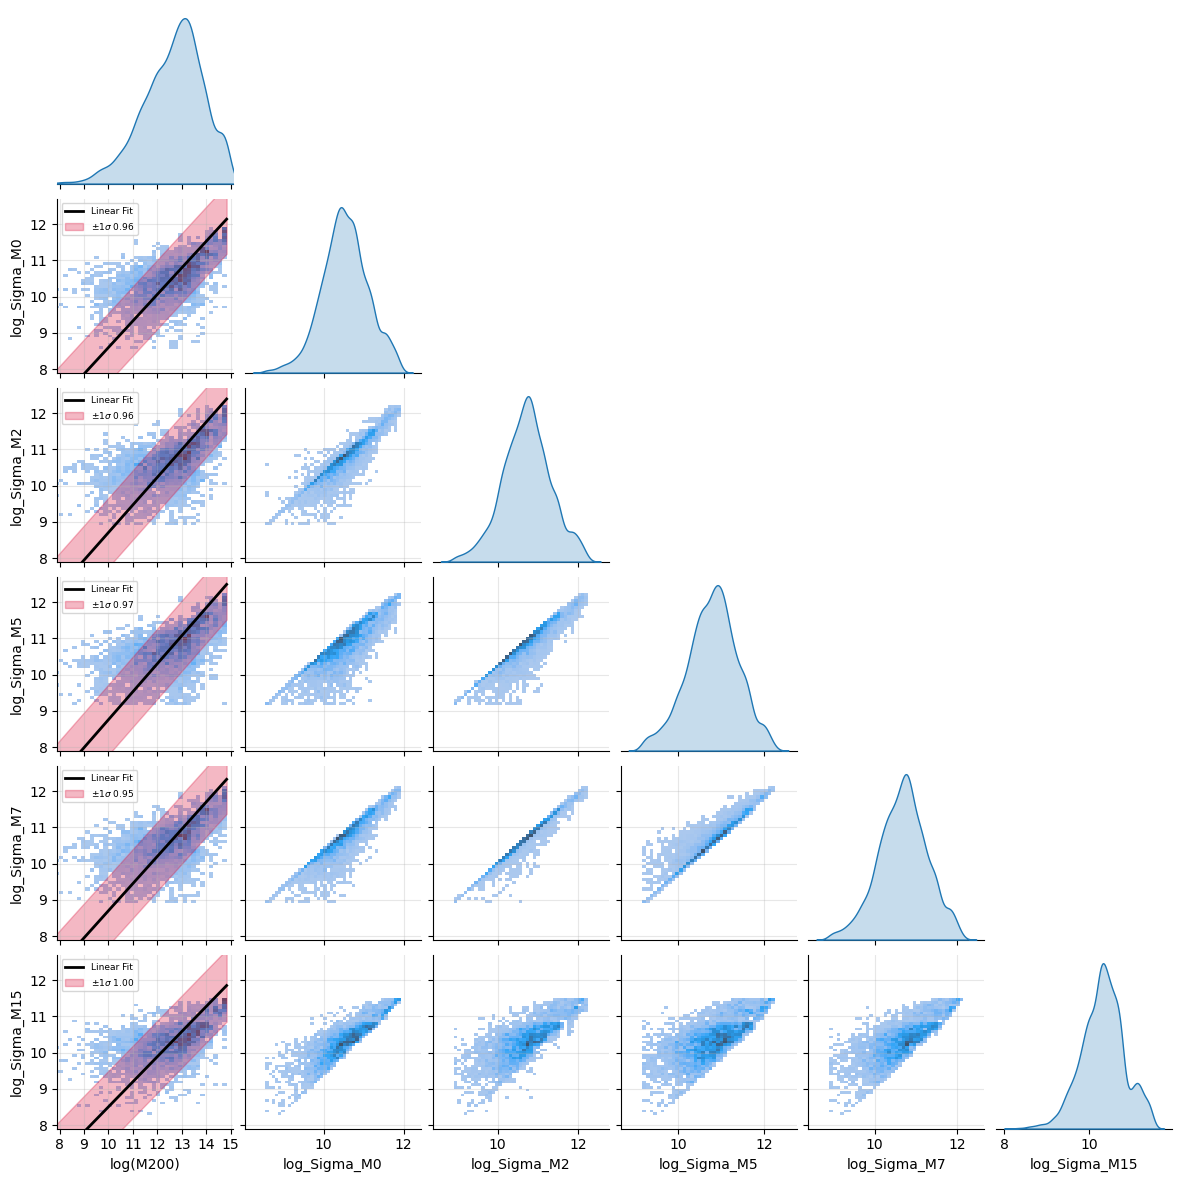

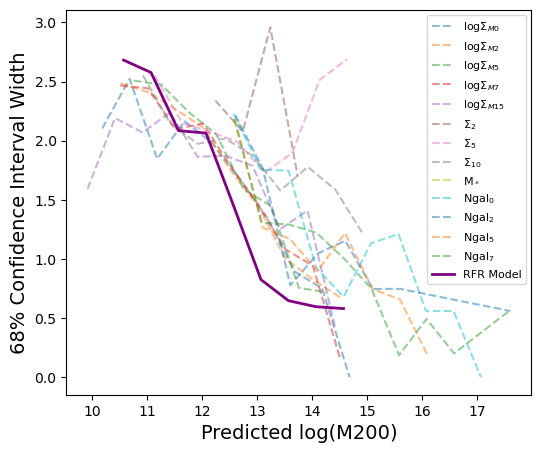

In [218]:
%run plot_single_correlations.py

**NOTE: Models Two and Three are now relatively obsolete by virtue of the relative robustness of Model One. I nevertheless keep them here for demonstration purposes on how to use Random Forest Classification. :-)**

#### MODEL TWO
##### Random Forest M200 Classification (Tempel+2017 groups and M200)
###### 0 = [12.5<M200], 1 = [12.5<M200<14.],  2 = [M200>14.]
###### Best result: 78.00% accuracy 

In [52]:
#note: using halo mass, so must isolate Tempel+2017 group galaxies (which actually have a halo mass)
df_group = df.copy()[df['tempel2017_groupIDs']>0]

In [55]:
#convert M200 to log(M200)
df_group['group_M200'] = np.log10(df_group['group_M200'])

In [56]:
#replace -999 with NaNs, in case there are any lingering buggers
df_group.replace(-999, np.nan, inplace=True)

#REMOVE NaNs
df_group = df_group.dropna()

In [213]:
#M200 bins
bin1 = df_group['group_M200'] < 12.5
bin2 = (df_group['group_M200'] >= 12.5) & (df_group['group_M200'] < 14.)
bin3 = (df_group['group_M200'] >= 14.)

df_group.loc[:, 'env_class'] = np.select([bin1, bin2, bin3], [0, 1, 2])

In [214]:
#check whether number of galaxies in each "bin" is relatively balanced
print(df_group['env_class'].value_counts())

env_class
1    2231
0    2002
2     516
Name: count, dtype: int64


In [318]:
#define your model of choice
model = RandomForestClassifier(
    n_estimators=80,
    max_depth=14,
    class_weight='balanced',
    random_state=42,
    max_features='sqrt')

In [312]:
#define general X, y sets
X = df_group[full_feature_list]
y = df_group['env_class']

In [217]:
#find optimal feature set for the model
selected_features = average_model_score(X, y, model=model, scoring='f1_macro',
                     n_splits=5, n_repeats=10, random_state=1)

Optimal number of features: 11
Selected features: ['Sigma_M14', 'ratio_SigmaM_1', 'ratio_SigmaM_2', 'Sigma_5', 'SigmaM_group1_pca', 'SigmaM_group2_pca', 'Sigma10_20_pca', 'Sigma2_3_pca', 'SigmaNgal1_pca', 'SigmaM_group3_pca', 'SigmaNgal2_pca']
Mean f1_macro: 0.7688
Standard Deviation: 0.016175347428291076


In [313]:
#define the optimal feature set...
X = df_group[selected_features]

In [319]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [320]:
#train ze model
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=14, n_estimators=80,
                       random_state=42)

In [321]:
y_pred = model.predict(X_test)

In [322]:
accuracy = (np.sum(np.diag(confusion_matrix(y_test, y_pred)))) / (np.sum(confusion_matrix(y_test, y_pred))) 
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 76.00%


In [323]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.737     0.805     0.770       401
           1      0.769     0.711     0.739       446
           2      0.820     0.796     0.808       103

    accuracy                          0.760       950
   macro avg      0.776     0.771     0.772       950
weighted avg      0.761     0.760     0.760       950



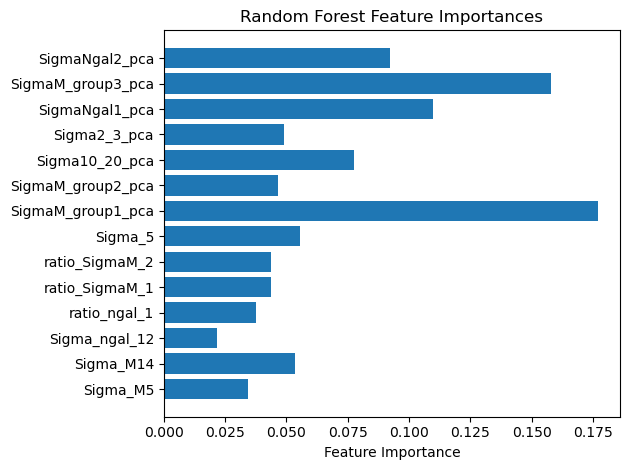

In [324]:
importances = model.feature_importances_
features = X.columns

plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

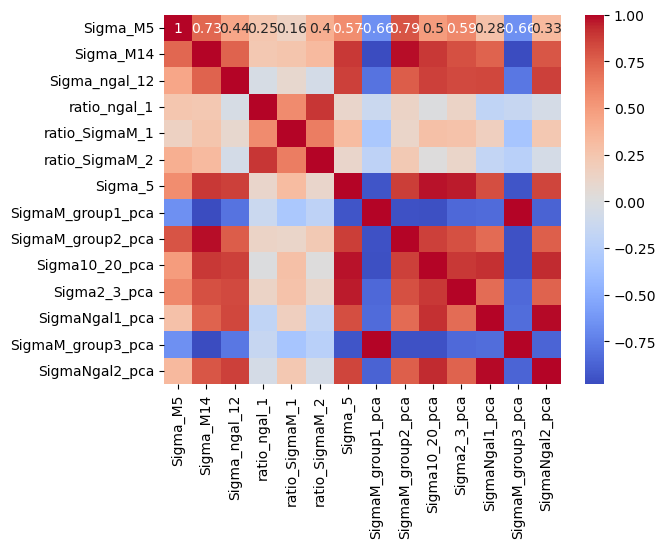

In [325]:
#CORRELATION MAP! Check if there are any redundant features (correlation > 0.95 or so)

find_correlations(X.corr())

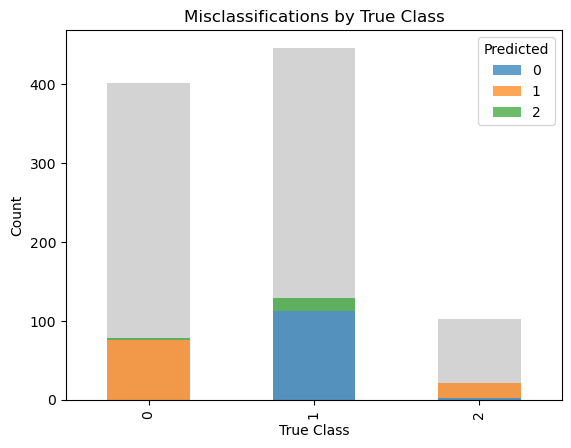

In [326]:
plot_misclassifications(y_test, y_pred)

NOTE: F1 is a sort of 'harmonic mean' of precision ("out of all positive predictions, how many were corect?") and recall ("out of all active positives, how many did the model catch?"). High F1 --> high precision and high recall. 

A 'harmonic mean' punishes extreme imbalances.

A high f1_macro corresponds to the model performing with robust precision AND recall for every class.

#### MODEL THREE
##### Random Forest Environment Classification (Tempel+2017 environment flags)
###### 0 = field, 1 = group/cluster
###### Best result: 78.49% accuracy
----
###### 0 = field, 1 = group, 2 = cluster
###### Best result: 75.51% accuracy

In [401]:
#replace -999 with NaNs
df_out.replace(-999, np.nan, inplace=True)

#REMOVE NaNs
df_out = df_out.dropna()

In [402]:
#just creating 0, 1, 2 classes based on Tempel flags --> 0 field, 1 group, 2 cluster

#df_out['env_class'] = np.select([df_out['tempel_field_flag'],
#                                 (df_out['tempel2017_group_flag'])|(df['tempel2017_cluster_flag'])],
#                [0, 1])

df_out['env_class'] = np.select([df_out['tempel_field_flag'],
                                 df_out['tempel2017_group_flag'],df_out['tempel2017_cluster_flag']],
                [0, 1, 2])

In [403]:
model = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=80, max_depth=14)

In [404]:
#define general X, y sets
X = df_out[full_feature_list]
y = df_out['env_class']

In [284]:
#find optimal feature set for the model
selected_features = average_model_score(X, y, model=model, scoring='f1_macro',
                     n_splits=5, n_repeats=10, random_state=1)

Optimal number of features: 15
Selected features: ['Sigma_M5', 'Sigma_M14', 'Sigma_ngal_5', 'Sigma_ngal_12', 'ratio_ngal_1', 'ratio_SigmaM_1', 'ratio_SigmaM_2', 'Sigma_5', 'SigmaM_group1_pca', 'SigmaM_group2_pca', 'Sigma10_20_pca', 'Sigma2_3_pca', 'SigmaNgal1_pca', 'SigmaM_group3_pca', 'SigmaNgal2_pca']
Mean f1_macro: 0.7671
Standard Deviation: 0.01296222447437044


In [366]:
#X =df_out[['Sigma_ngal_5', 'Sigma_ngal_12', 'ratio_ngal_1', 
#           'ratio_SigmaM_1', 'ratio_SigmaM_2', 'Sigma_5', 'SigmaM_group1_pca', 
#           'SigmaM_group2_pca', 'Sigma10_20_pca', 'Sigma2_3_pca', 'SigmaNgal1_pca']]

#X=df_out[selected_features]

In [405]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [406]:
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=14, n_estimators=80,
                       random_state=42)

In [407]:
y_pred = model.predict(X_test)

In [408]:
accuracy = (np.sum(np.diag(confusion_matrix(y_test, y_pred)))) / (np.sum(confusion_matrix(y_test, y_pred))) 
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 77.32%


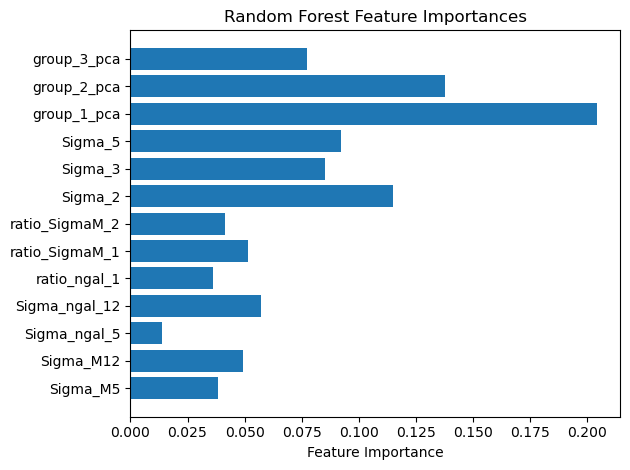

In [409]:
importances = model.feature_importances_
features = X.columns

plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

<Axes: >

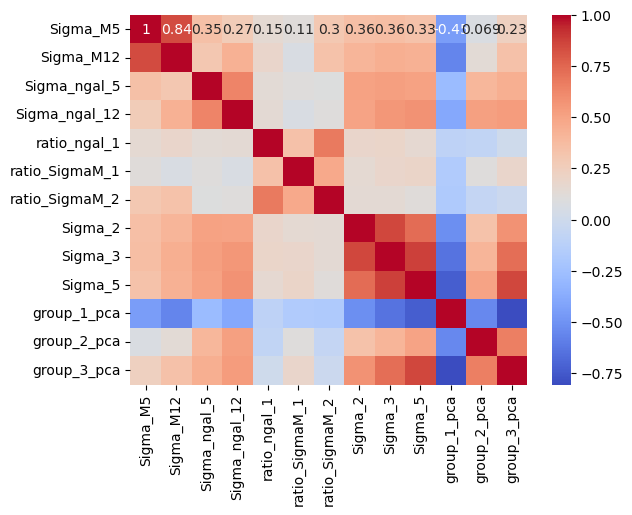

In [410]:
#CORRELATION MAP! Check if there are any redundant features (correlation > 0.95 or so)

import seaborn as sns
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')

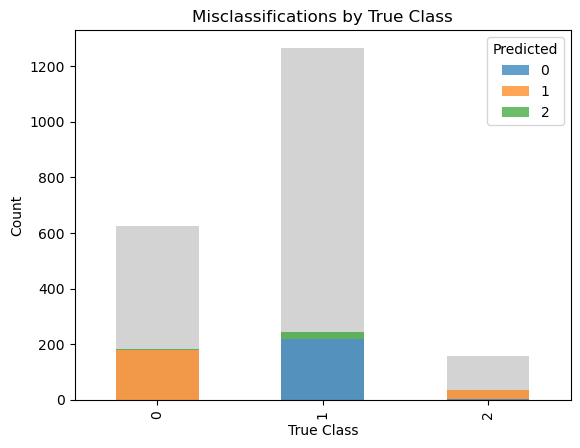

In [411]:
plot_misclassifications(y_test, y_pred)